# 🫁 MSCViT - Chest X-ray Multi-Label Classification

**Dataset:** CheXpert 3-class (Cardiomegaly, Edema, Pneumothorax) - No Finding Excluded

**Model:** MSCViT-T (Multi-Scale Channel Vision Transformer - Tiny)

**Outputs:**
- 3 Binary Classification Reports (one per class)
- 3 Binary Confusion Matrices (one per class)
- Training/Validation Loss & Accuracy Curves
- ROC Curves for all 3 classes

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Torchvision
import torchvision.transforms as transforms

# Sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, accuracy_score, f1_score,
    precision_score, recall_score
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


## ⚙️ Configuration

In [19]:
class Config:
    # Paths - UPDATE THIS TO YOUR DATASET NAME
    DATA_DIR = "/kaggle/input"  # Your uploaded dataset
    OUTPUT_DIR = "/kaggle/working"
    
    # Model
    MODEL_NAME = "convnext"
    NUM_CLASSES = 3
    LABELS = ["Cardiomegaly", "Edema", "Pneumothorax"]
    
    # Training
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # Image
    IMG_SIZE = 224
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Random seed
    SEED = 42

config = Config()

# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.SEED)

print(f"🖥️ Device: {config.DEVICE}")
print(f"🤖 Model: {config.MODEL_NAME}")
print(f"🏷️ Labels: {config.LABELS}")

🖥️ Device: cuda
🤖 Model: convnext
🏷️ Labels: ['Cardiomegaly', 'Edema', 'Pneumothorax']


## 📦 Dataset Class

In [20]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = config.LABELS
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get image path
        img_path = row['new_path']
        full_path = os.path.join(self.img_dir, img_path)
        
        # Load image
        try:
            image = Image.open(full_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {full_path}: {e}")
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        # Get labels (multi-hot encoding)
        labels = []
        for label in self.labels:
            val = row[label] if label in row.index else 0
            labels.append(1.0 if val == 1.0 else 0.0)
        
        labels = torch.tensor(labels, dtype=torch.float32)
        
        return image, labels

## 🎨 Data Augmentation

In [21]:
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 📊 Load CheXpert Dataset

In [22]:
import os

print(os.listdir("/kaggle/input"))

['images', 'metadata.csv']


In [23]:
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Check what's in the data directory
print(f"\nContents of {config.DATA_DIR}:")
if os.path.exists(config.DATA_DIR):
    for item in os.listdir(config.DATA_DIR):
        print(f"  {item}")
else:
    print(f"  ⚠️ Directory {config.DATA_DIR} not found. Please check dataset path.")

# Load metadata
metadata_path = os.path.join(config.DATA_DIR, "metadata.csv")
if os.path.exists(metadata_path):
    df = pd.read_csv(metadata_path)
    print(f"\n📈 Total samples: {len(df)}")

    # Check label distribution
    print("\n📊 Label distribution:")
    for label in config.LABELS:
        if label in df.columns:
            count = (df[label] == 1.0).sum()
            print(f"  {label}: {count} ({count/len(df)*100:.2f}%)")
else:
    # Fallback for testing without data
    print("⚠️ Metadata file not found. Creating dummy data structure for compilation check.")
    df = pd.DataFrame(columns=['new_path'] + config.LABELS)

LOADING DATA

Contents of /kaggle/input:
  images
  metadata.csv

📈 Total samples: 95060

📊 Label distribution:
  Cardiomegaly: 23451 (24.67%)
  Edema: 49717 (52.30%)
  Pneumothorax: 17700 (18.62%)


In [24]:
# Split data
if len(df) > 0:
    train_df, val_df = train_test_split(
        df, test_size=0.2, random_state=config.SEED, 
        stratify=None
    )
else:
    train_df, val_df = df, df

print(f"🏋️ Train samples: {len(train_df)}")
print(f"🧪 Validation samples: {len(val_df)}")

# Create datasets
train_dataset = ChestXrayDataset(train_df, config.DATA_DIR, train_transform)
val_dataset = ChestXrayDataset(val_df, config.DATA_DIR, val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"\n✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

🏋️ Train samples: 76048
🧪 Validation samples: 19012

✅ DataLoaders created!
   Train batches: 2377
   Val batches: 595


## 🤖 MSCViT Model Definition

In [25]:
# MSCViT Model Configuration
MSCViT_CONFIGS = {
    "MSCViT-T": {
        "stem_channels": 16,
        "stages": [
            {"C": 32,  "P": 3, "R": 4},
            {"C": 64,  "P": 3, "R": 3},
            {"C": 128, "P": 5, "R": 2},
            {"C": 256, "P": 5, "R": 1},
        ],
    },
}

class ConvStem(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

class DWConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dw = nn.Conv2d(dim, dim, 3, padding=1, groups=dim, bias=False)
        self.pw = nn.Conv2d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.pw(self.dw(x))))

class LFE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = DWConv(dim)

    def forward(self, x):
        return self.conv(x)

class ChannelMixer(nn.Module):
    def __init__(self, dim, expansion=2):
        super().__init__()
        hidden = dim * expansion
        self.fc1 = nn.Conv2d(dim, hidden, 1, bias=False)
        self.act = nn.GELU()
        self.fc2 = nn.Conv2d(hidden, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)

    def forward(self, x):
        return self.bn(self.fc2(self.act(self.fc1(x))))

class MSCBlock(nn.Module):
    def __init__(self, dim, attn_depth):
        super().__init__()
        self.lfe = LFE(dim)
        self.mixers = nn.ModuleList([
            ChannelMixer(dim)
            for _ in range(attn_depth)
        ])

    def forward(self, x):
        x = x + self.lfe(x)
        for m in self.mixers:
            x = x + m(x)
        return x

class Stage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, attn_depth):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.blocks = nn.ModuleList([
            MSCBlock(out_channels, attn_depth)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = self.downsample(x)
        for blk in self.blocks:
            x = blk(x)
        return x

class MSCViT(nn.Module):
    def __init__(self, variant="MSCViT-T", num_classes=3, global_pool="avg"):
        super().__init__()
        cfg = MSCViT_CONFIGS[variant]
        self.__class__.__name__ = variant

        self.stem = ConvStem(cfg["stem_channels"])
        in_ch = cfg["stem_channels"]
        self.stages = nn.ModuleList()

        for s in cfg["stages"]:
            self.stages.append(
                Stage(in_ch, s["C"], s["P"], s["R"])
            )
            in_ch = s["C"]

        self.head = nn.Linear(in_ch, num_classes) if num_classes > 0 else nn.Identity()
        self.global_pool = global_pool

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = x.mean((2, 3)) if self.global_pool == "avg" else x.amax((2, 3))
        return self.head(x)

# Create model
model = MSCViT("MSCViT-T", num_classes=config.NUM_CLASSES, global_pool="avg")
model = model.to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

📊 Total parameters: 3,017,523
📊 Trainable parameters: 3,017,523


## 🎯 Training Setup

In [26]:
# Loss function, optimizer, scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS, eta_min=1e-6)

print("✅ Training setup complete!")
print(f"  Loss: BCEWithLogitsLoss")
print(f"  Optimizer: AdamW (lr={config.LEARNING_RATE})")
print(f"  Scheduler: CosineAnnealingLR")

✅ Training setup complete!
  Loss: BCEWithLogitsLoss
  Optimizer: AdamW (lr=0.0001)
  Scheduler: CosineAnnealingLR


## 🔄 Training & Validation Functions

In [28]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())
    
    avg_loss = running_loss / len(loader)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = ((all_preds > 0.5) == all_labels).float().mean().item()
    
    return avg_loss, accuracy

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())
    
    avg_loss = running_loss / len(loader)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = ((all_preds > 0.5) == all_labels).float().mean().item()
    
    return avg_loss, accuracy, all_preds, all_labels

## 🚀 Training Loop

In [30]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_model_path = os.path.join(config.OUTPUT_DIR, 'mscvit_chestxray.pth')

print("🏋️ Starting training...\n")

for epoch in range(config.NUM_EPOCHS-20):
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS-20}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, config.DEVICE)
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}\n")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, best_model_path)
        print(f"  💾 Saved best model (val_loss: {val_loss:.4f})\n")

print("✅ Training complete!")

🏋️ Starting training...

Epoch 1/5


  Train Loss: 0.4731 | Train Acc: 0.7793
  Val Loss: 0.4483 | Val Acc: 0.7890
  LR: 0.000100

  💾 Saved best model (val_loss: 0.4483)

Epoch 2/5


  Train Loss: 0.4355 | Train Acc: 0.8000
  Val Loss: 0.4721 | Val Acc: 0.7865
  LR: 0.000098

Epoch 3/5


  Train Loss: 0.4184 | Train Acc: 0.8094
  Val Loss: 0.4343 | Val Acc: 0.7992
  LR: 0.000097

  💾 Saved best model (val_loss: 0.4343)

Epoch 4/5


  Train Loss: 0.4041 | Train Acc: 0.8172
  Val Loss: 0.4241 | Val Acc: 0.8080
  LR: 0.000094

  💾 Saved best model (val_loss: 0.4241)

Epoch 5/5


  Train Loss: 0.3881 | Train Acc: 0.8264
  Val Loss: 0.4231 | Val Acc: 0.8065
  LR: 0.000091

  💾 Saved best model (val_loss: 0.4231)

✅ Training complete!


## 📈 Training Curves

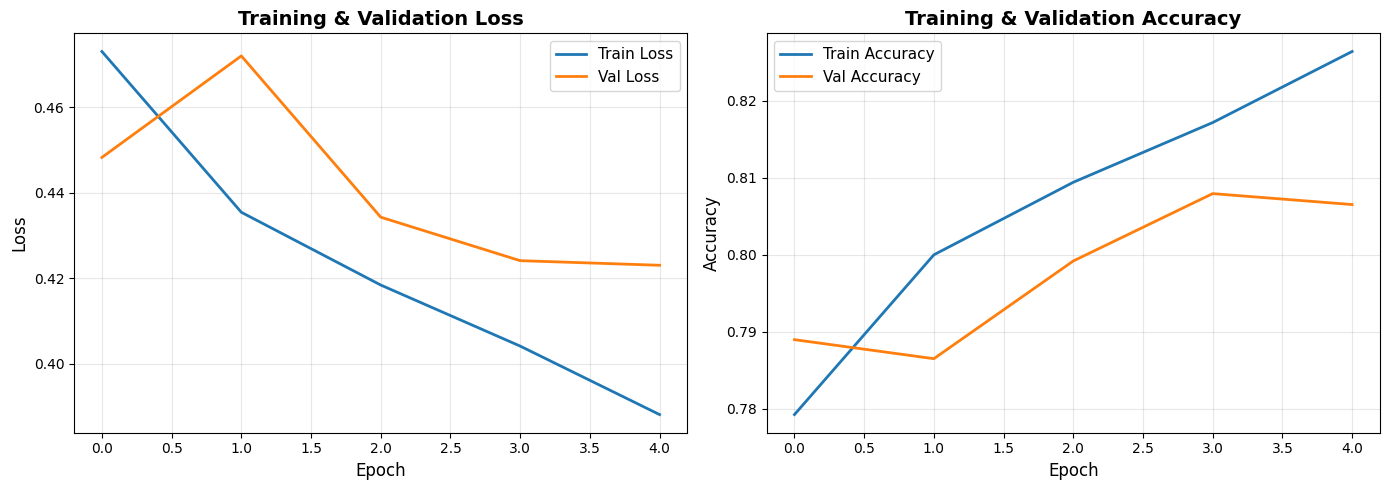

✅ Saved: mscvit_training_curves.png


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'mscvit_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: mscvit_training_curves.png")

## 📊 Evaluation - Load Best Model

In [32]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val Acc: {checkpoint['val_acc']:.4f}")

# Get predictions
_, val_acc, all_probs, all_labels = validate_epoch(model, val_loader, criterion, config.DEVICE)
all_preds = (all_probs > 0.5).float()

all_preds = all_preds.numpy()
all_probs = all_probs.numpy()
all_labels = all_labels.numpy()

print(f"\n📊 Predictions shape: {all_preds.shape}")
print(f"📊 Labels shape: {all_labels.shape}")

✅ Loaded best model from epoch 4
   Val Loss: 0.4231
   Val Acc: 0.8065



📊 Predictions shape: (19012, 3)
📊 Labels shape: (19012, 3)


## 📋 Per-Class Classification Reports

In [33]:
reports_data = []

for i, label in enumerate(config.LABELS):
    print(f"\n{'='*60}")
    print(f"📊 {label}")
    print(f"{'='*60}")
    
    y_true = all_labels[:, i]
    y_pred = all_preds[:, i]
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    reports_data.append({
        'Label': label,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Save to CSV
reports_df = pd.DataFrame(reports_data)
reports_df.to_csv(os.path.join(config.OUTPUT_DIR, 'mscvit_classification_reports.csv'), index=False)
print(f"\n✅ Saved: mscvit_classification_reports.csv")
print(f"\n{reports_df}")


📊 Cardiomegaly
              precision    recall  f1-score   support

    Negative       0.85      0.92      0.88     14301
    Positive       0.67      0.50      0.57      4711

    accuracy                           0.81     19012
   macro avg       0.76      0.71      0.73     19012
weighted avg       0.80      0.81      0.80     19012


📊 Edema
              precision    recall  f1-score   support

    Negative       0.73      0.80      0.76      9067
    Positive       0.80      0.73      0.76      9945

    accuracy                           0.76     19012
   macro avg       0.77      0.77      0.76     19012
weighted avg       0.77      0.76      0.76     19012


📊 Pneumothorax
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90     15416
    Positive       0.59      0.55      0.57      3596

    accuracy                           0.84     19012
   macro avg       0.74      0.73      0.74     19012
weighted avg       0.84      0.84

## 🔲 Confusion Matrices

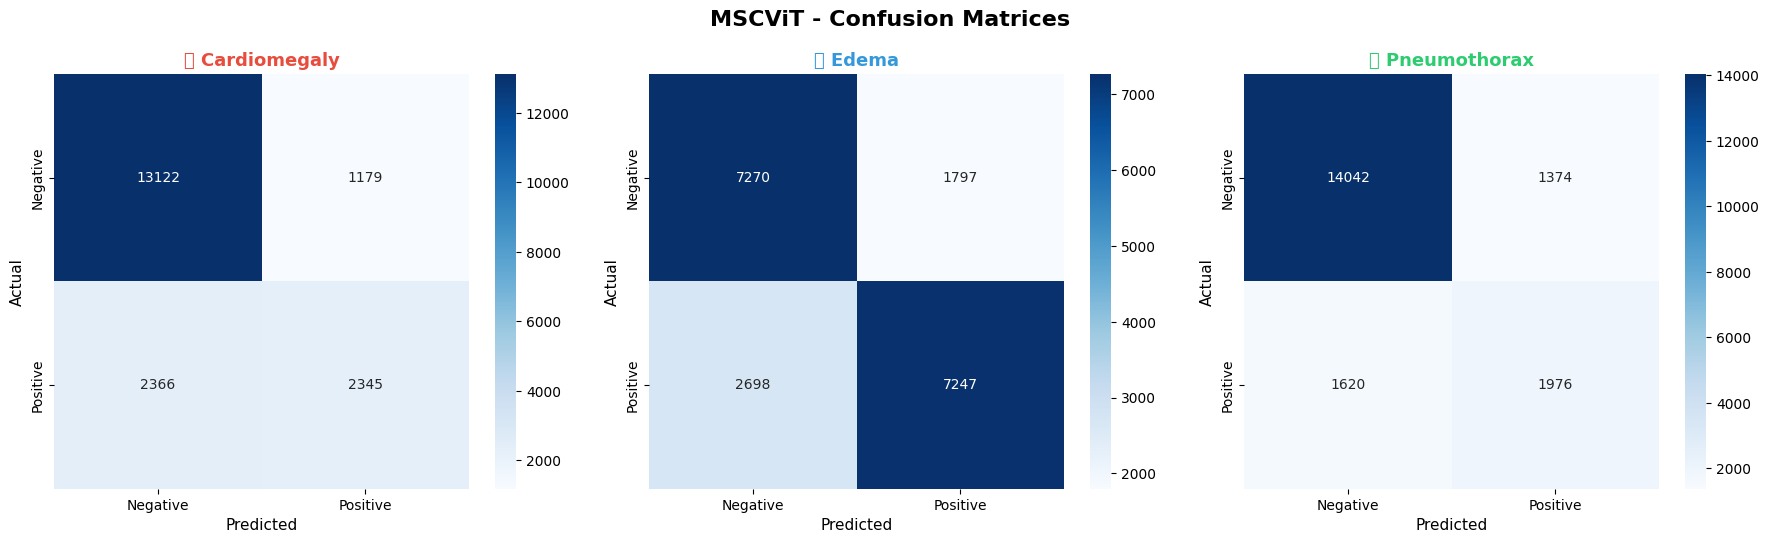

✅ Saved: mscvit_confusion_matrices.png


In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, label in enumerate(config.LABELS):
    y_true = all_labels[:, i]
    y_pred = all_preds[:, i]
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[i], cbar=True, square=True)
    
    axes[i].set_xlabel('Predicted', fontsize=11)
    axes[i].set_ylabel('Actual', fontsize=11)
    axes[i].set_title(f'🏷️ {label}', fontsize=13, fontweight='bold', color=colors[i])

plt.suptitle('MSCViT - Confusion Matrices', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'mscvit_confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: mscvit_confusion_matrices.png")

## 📊 Metrics Comparison

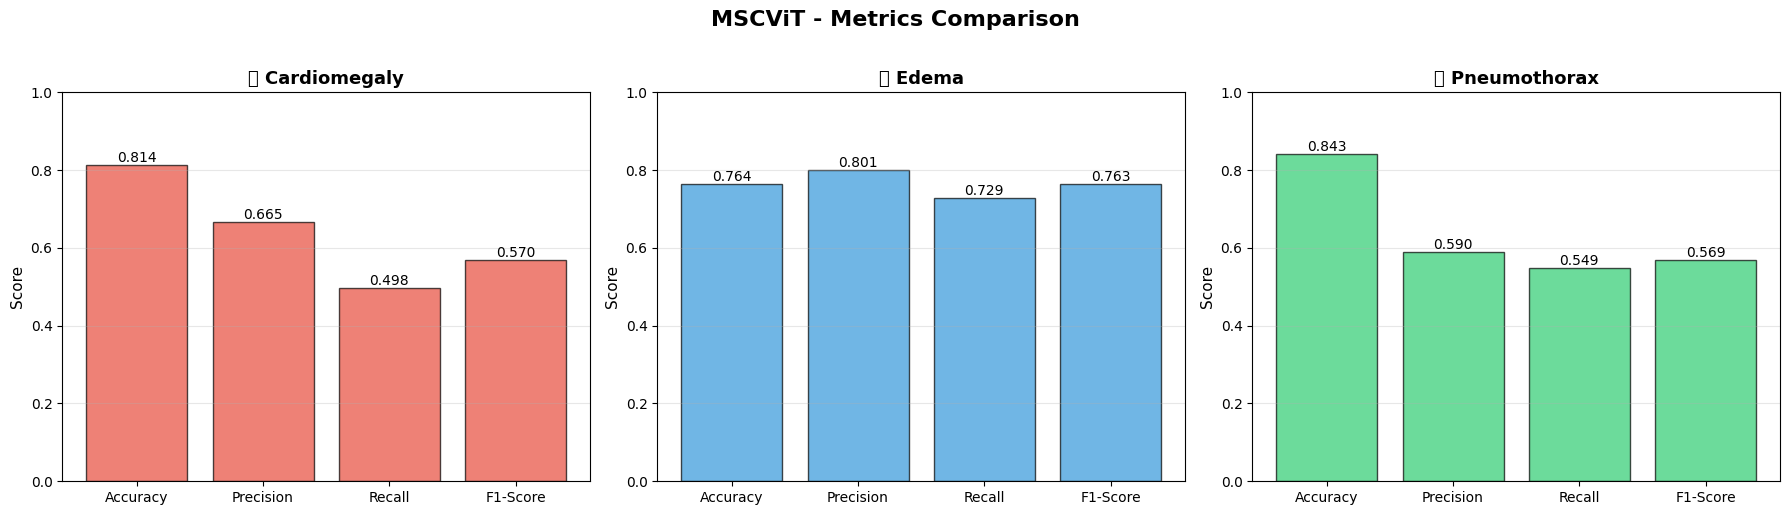

✅ Saved: mscvit_metrics_comparison.png


In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#e74c3c', '#3498db', '#2ecc71']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, label in enumerate(config.LABELS):
    values = reports_df[reports_df['Label'] == label][metrics].values[0]
    
    bars = axes[i].bar(metrics, values, color=colors[i], alpha=0.7, edgecolor='black')
    axes[i].set_ylim([0, 1])
    axes[i].set_ylabel('Score', fontsize=11)
    axes[i].set_title(f'🏷️ {label}', fontsize=13, fontweight='bold')
    axes[i].grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('MSCViT - Metrics Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'mscvit_metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: mscvit_metrics_comparison.png")

## 📈 ROC Curves

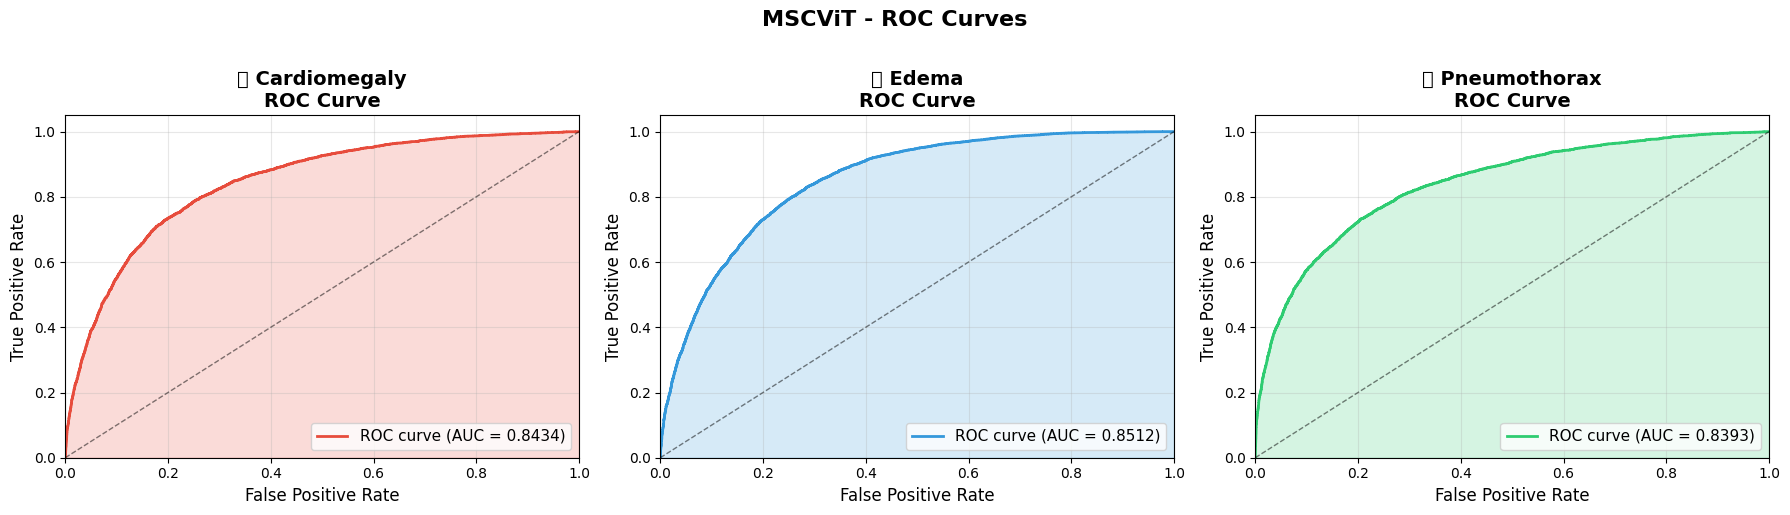

✅ Saved: mscvit_roc_curves.png


In [36]:
if len(all_preds) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['#e74c3c', '#3498db', '#2ecc71']

    for i, label in enumerate(config.LABELS):
        class_probs = all_probs[:, i]
        class_labels = all_labels[:, i]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(class_labels, class_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        axes[i].plot(fpr, tpr, color=colors[i], linewidth=2, 
                     label=f'ROC curve (AUC = {roc_auc:.4f})')
        axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
        axes[i].fill_between(fpr, tpr, alpha=0.2, color=colors[i])
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate', fontsize=12)
        axes[i].set_ylabel('True Positive Rate', fontsize=12)
        axes[i].set_title(f'🏷️ {label}\nROC Curve', fontsize=14, fontweight='bold')
        axes[i].legend(loc='lower right', fontsize=11)
        axes[i].grid(True, alpha=0.3)

    plt.suptitle('MSCViT - ROC Curves', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'mscvit_roc_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: mscvit_roc_curves.png")

## 🎉 Final Summary

In [37]:
print("="*60)
print("🎉 TRAINING COMPLETE! - MSCViT")
print("="*60)

if len(all_preds) > 0:
    print(f"""
    🤖 Model: MSCViT-T
    📊 Dataset: CheXpert (3-class: {', '.join(config.LABELS)})
    🏋️ Training samples: {len(train_df)}
    🧪 Validation samples: {len(val_df)}

    📉 Best Validation Loss: {best_val_loss:.4f}
    📈 Final Validation Accuracy: {val_acc:.4f}

    📁 Output Files:
      📊 mscvit_training_curves.png
      📊 mscvit_confusion_matrices.png
      📊 mscvit_metrics_comparison.png
      📊 mscvit_roc_curves.png
      📄 mscvit_classification_reports.csv
      🔧 mscvit_chestxray.pth

    📋 Per-Class Performance:
    """)

    for _, row in reports_df.iterrows():
        print(f"  {row['Label']}: Acc={row['Accuracy']:.4f} | F1={row['F1-Score']:.4f}")

    print("\n✅ All outputs saved successfully!")
else:
    print("⚠️ No results to report.")

🎉 TRAINING COMPLETE! - MSCViT

    🤖 Model: MSCViT-T
    📊 Dataset: CheXpert (3-class: Cardiomegaly, Edema, Pneumothorax)
    🏋️ Training samples: 76048
    🧪 Validation samples: 19012

    📉 Best Validation Loss: 0.4231
    📈 Final Validation Accuracy: 0.8065

    📁 Output Files:
      📊 mscvit_training_curves.png
      📊 mscvit_confusion_matrices.png
      📊 mscvit_metrics_comparison.png
      📊 mscvit_roc_curves.png
      📄 mscvit_classification_reports.csv
      🔧 mscvit_chestxray.pth

    📋 Per-Class Performance:
    
  Cardiomegaly: Acc=0.8135 | F1=0.5695
  Edema: Acc=0.7636 | F1=0.7633
  Pneumothorax: Acc=0.8425 | F1=0.5690

✅ All outputs saved successfully!
